<a href="https://colab.research.google.com/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/dkaratzas/DL2022-23/blob/main/Problems%207%20-%20Autoencoders/P7_Autoencoders.ipynb)

# Autoencoders

In this notebook we will explore three different types of autoencoder architectures: Simple MLP Autoencoder, Convolutional Autoencoder and Variational Autoencoder (VAE). We will also see how we can use VAEs to generate new data.

In [57]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import matplotlib.pyplot as plt
import numpy as np

# Setting up

In [58]:
#If this cell fails you need to change the runtime of your colab notebook to GPU
# Go to Runtime -> Change Runtime Type and select GPU
assert torch.cuda.is_available(), "GPU is not enabled"

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
def show_image(img):
    img = img.clamp(0, 1) # Ensure that the range of greyscales is between 0 and 1
    npimg = img.numpy()   # Convert to NumPy
    npimg = np.transpose(npimg, (2, 1, 0))   # Change the order to (W, H, C)
    plt.imshow(npimg)
    plt.show()

In [60]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=2
)

# Simple Autoencoder

We will define a simple MLP Autoencoder

In [61]:
class AE(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [62]:
model = AE(input_size=784).to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

Define the training and testing loops

In [63]:
def train(model, loader, optimizer, criterion, reshape=False):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions
        outputs = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))

def test(model, loader, criterion, reshape=False):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        if reshape:
            batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

epoch : 1/10, Train loss = 0.048824
epoch : 1/10, Test loss = 0.025412


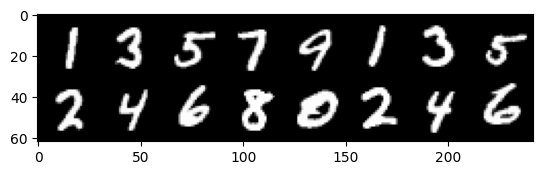

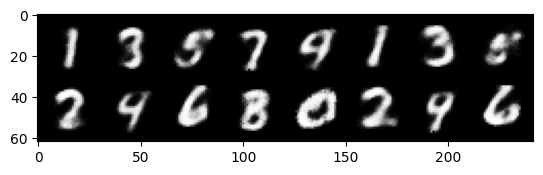

epoch : 2/10, Train loss = 0.020637
epoch : 2/10, Test loss = 0.016560


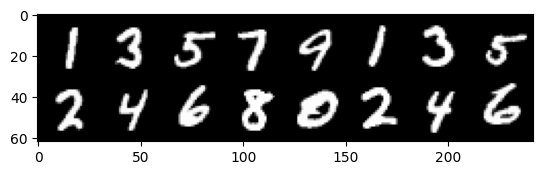

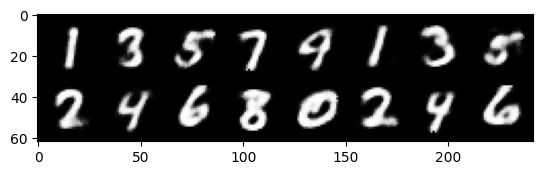

epoch : 3/10, Train loss = 0.014950
epoch : 3/10, Test loss = 0.013024


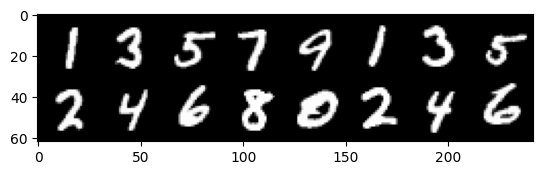

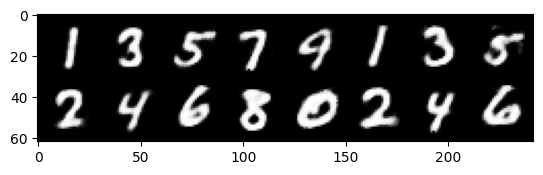

epoch : 4/10, Train loss = 0.012329
epoch : 4/10, Test loss = 0.011071


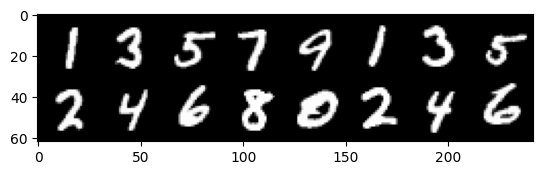

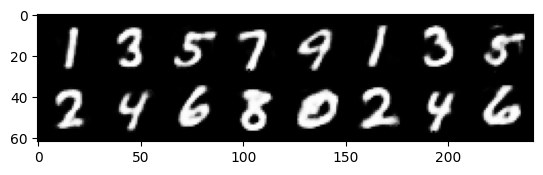

epoch : 5/10, Train loss = 0.010682
epoch : 5/10, Test loss = 0.009753


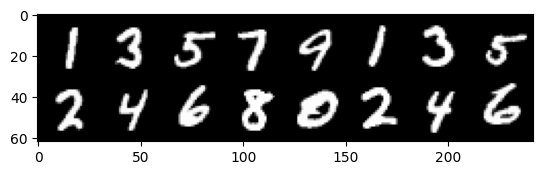

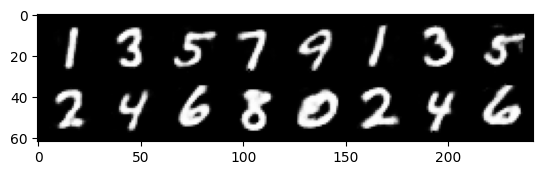

epoch : 6/10, Train loss = 0.009595
epoch : 6/10, Test loss = 0.008851


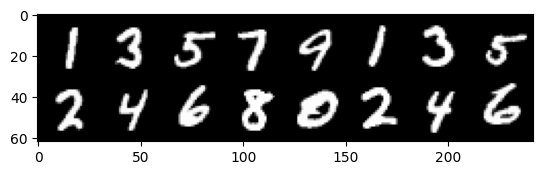

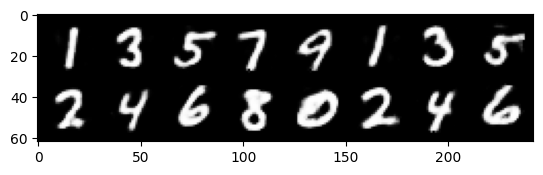

epoch : 7/10, Train loss = 0.008784
epoch : 7/10, Test loss = 0.008149


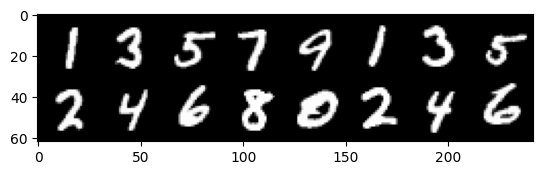

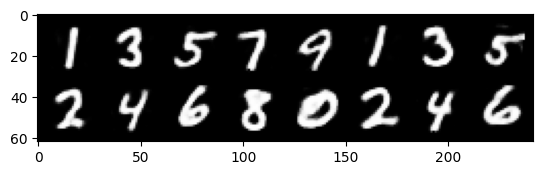

epoch : 8/10, Train loss = 0.008157
epoch : 8/10, Test loss = 0.007592


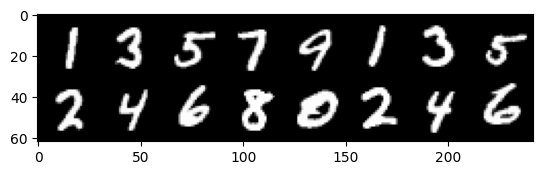

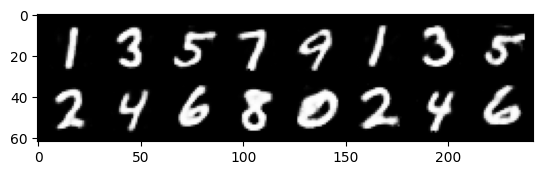

epoch : 9/10, Train loss = 0.007650
epoch : 9/10, Test loss = 0.007151


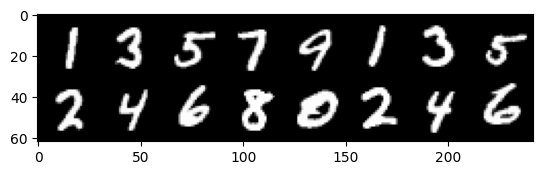

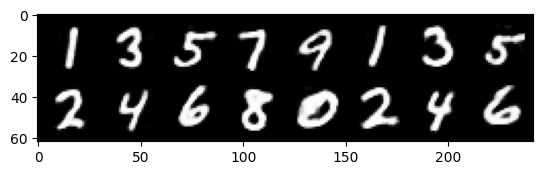

epoch : 10/10, Train loss = 0.007202
epoch : 10/10, Test loss = 0.006780


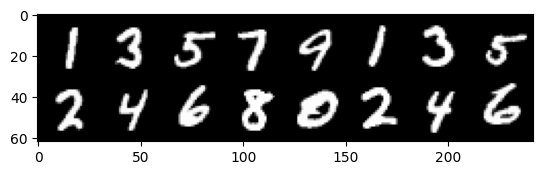

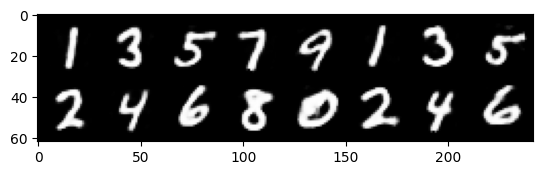

In [64]:
epochs=10
for epoch in range(epochs):
    train(model, train_loader, optimizer, criterion, reshape=True)
    test(model, test_loader, criterion, reshape=True)

# Convolutional Autoencoder

We will now build a convolutional Autoencoder. Below you can find an incomplete implementation of one (only the encoder part)...

In [65]:
class ConvAE(nn.Module):
    def __init__(self):
        super(ConvAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

<span style="color:blue">

**Exercise 1**: Build the decoder for the convolutional autoencoder model above and train it using the same functions and hyper-parameters as defined above.

> Hint: Use only deconvolutions (design an non-symmetric architecture) so that you do not have to store indices for the unpooling layers. Have a look at `ConvTranspose2d()` https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html

    
> Hint: Remember that to calculate the new activation map's size while deconvolving you should use: $𝑛^{[𝑙]} =(𝑛^{[𝑙−1]}−1) 𝑠 − 2𝑝 + 𝑓$
    
</span>

epoch : 1/10, Train loss = 0.075537
epoch : 1/10, Test loss = 0.042842


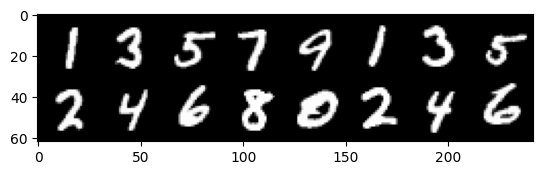

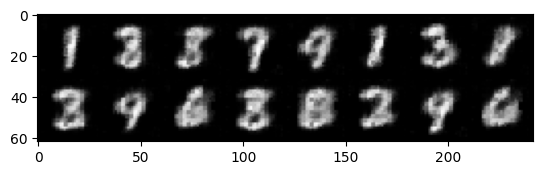

epoch : 2/10, Train loss = 0.037194
epoch : 2/10, Test loss = 0.032522


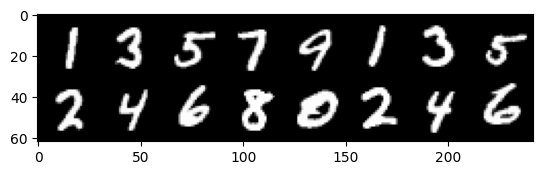

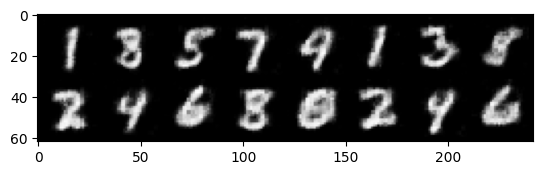

epoch : 3/10, Train loss = 0.031483
epoch : 3/10, Test loss = 0.029557


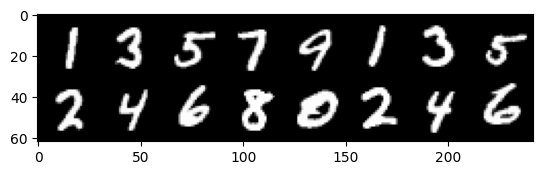

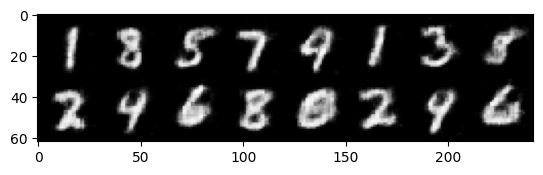

epoch : 4/10, Train loss = 0.029611
epoch : 4/10, Test loss = 0.028342


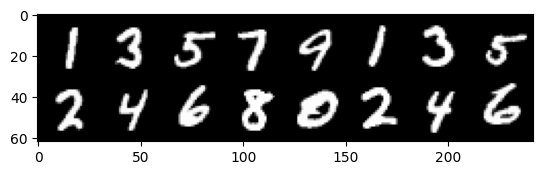

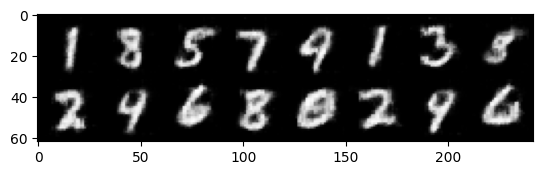

epoch : 5/10, Train loss = 0.028376
epoch : 5/10, Test loss = 0.027108


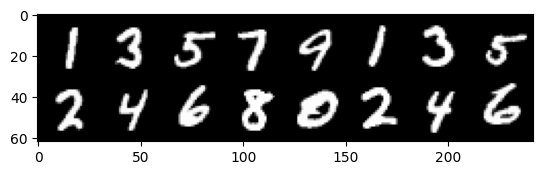

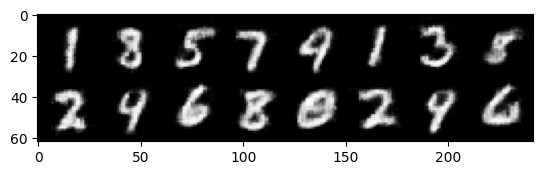

epoch : 6/10, Train loss = 0.027410
epoch : 6/10, Test loss = 0.026491


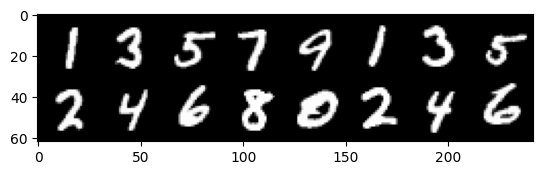

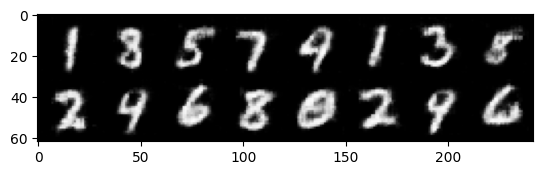

epoch : 7/10, Train loss = 0.026855
epoch : 7/10, Test loss = 0.026015


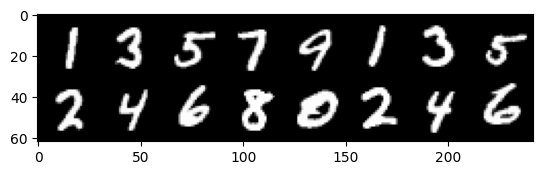

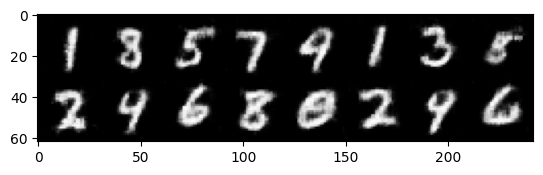

epoch : 8/10, Train loss = 0.026428
epoch : 8/10, Test loss = 0.025577


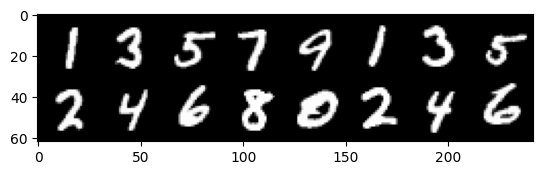

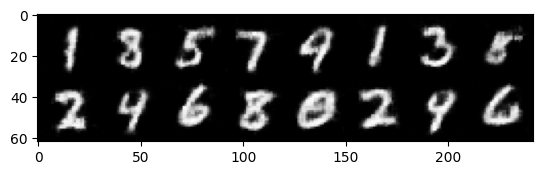

epoch : 9/10, Train loss = 0.026123
epoch : 9/10, Test loss = 0.025490


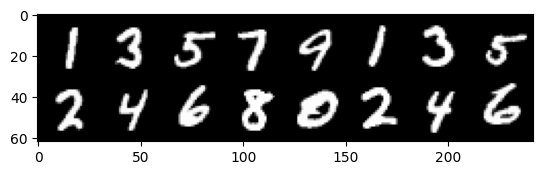

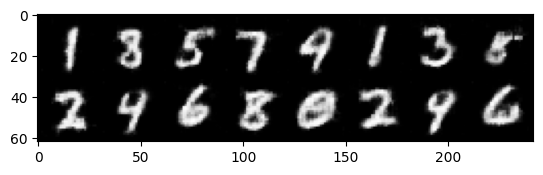

epoch : 10/10, Train loss = 0.025889
epoch : 10/10, Test loss = 0.025243


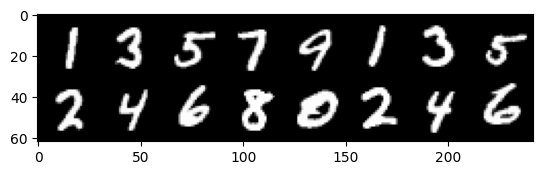

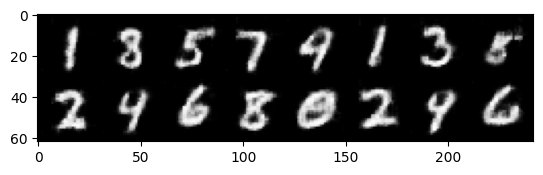

In [66]:
ConvAE = ConvAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader, criterion, reshape=False)


<span style="color:blue">

**Exercise 2 (HOMEWORK)**: Rebuild the network, but this time do a symmetric design for the decoder (using unpooling as required) and train it using the same functions and hyper-parameters as defined above.

> Hint: Have a look at `MaxUnpool2d()` https://pytorch.org/docs/stable/generated/torch.nn.MaxUnpool2d.html
    
</span>

In [67]:
from torch.nn.modules.pooling import MaxUnpool2d

class ConvAE_symmetric(nn.Module):
    def __init__(self):
        super(ConvAE_symmetric, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, return_indices=True),  # b, 16, 5, 5
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1, return_indices=True)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.MaxUnpool2d(2, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8,out_channels=16,kernel_size=3, stride=2, padding=1),
            nn.MaxUnpool2d(2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        indices_list = []

        for layer in self.encoder:
            if isinstance(layer, nn.MaxPool2d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)

        idx = 1

        for layer in self.decoder:
            if isinstance(layer, nn.MaxUnpool2d):
                x = layer(x, indices_list[-idx])
                idx += 1
            else:
                x = layer(x)
        return x

epoch : 1/10, Train loss = 0.128094
epoch : 1/10, Test loss = 0.071847


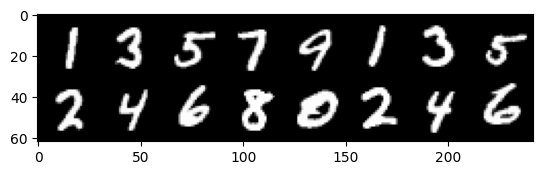

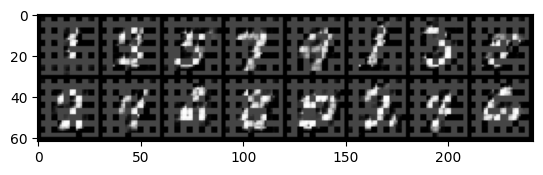

epoch : 2/10, Train loss = 0.051952
epoch : 2/10, Test loss = 0.037998


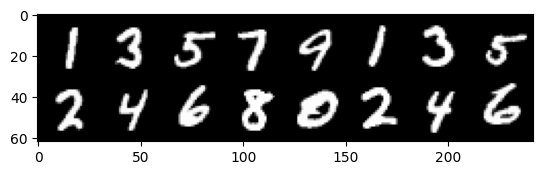

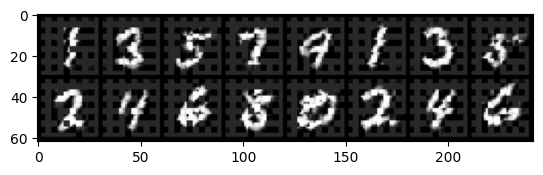

epoch : 3/10, Train loss = 0.033018
epoch : 3/10, Test loss = 0.028670


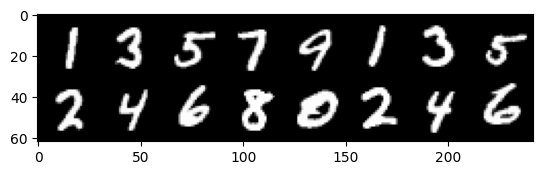

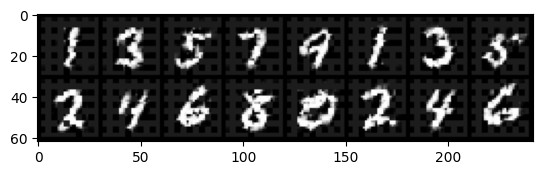

epoch : 4/10, Train loss = 0.026885
epoch : 4/10, Test loss = 0.025989


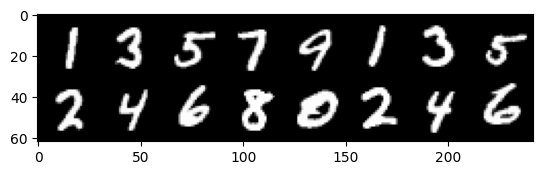

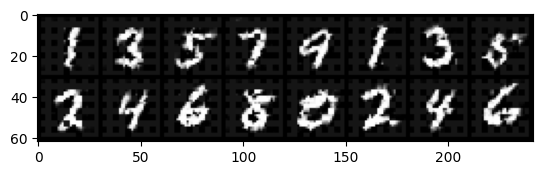

epoch : 5/10, Train loss = 0.024853
epoch : 5/10, Test loss = 0.024484


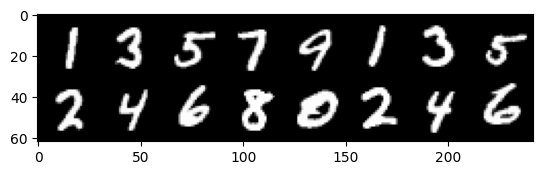

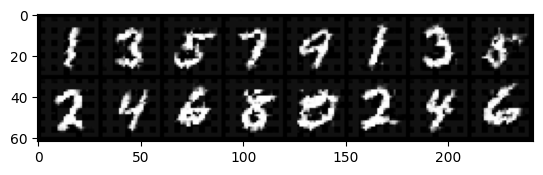

epoch : 6/10, Train loss = 0.023408
epoch : 6/10, Test loss = 0.022980


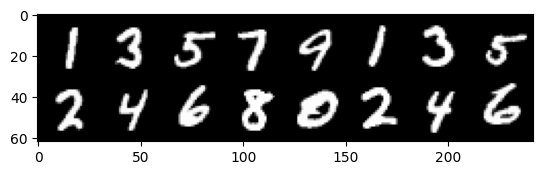

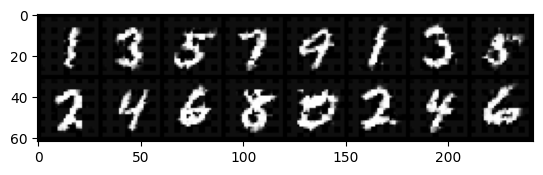

epoch : 7/10, Train loss = 0.022355
epoch : 7/10, Test loss = 0.022168


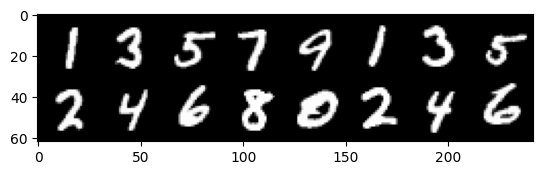

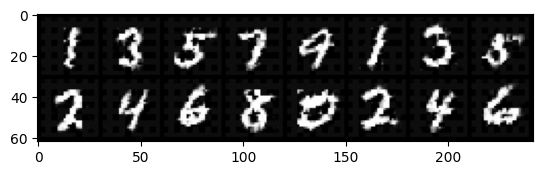

epoch : 8/10, Train loss = 0.021865
epoch : 8/10, Test loss = 0.021995


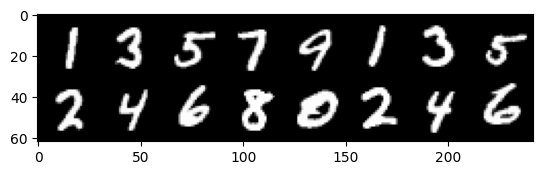

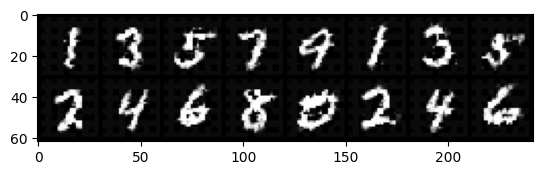

epoch : 9/10, Train loss = 0.021668
epoch : 9/10, Test loss = 0.021721


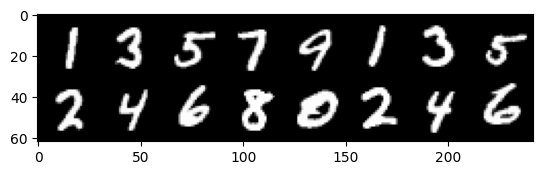

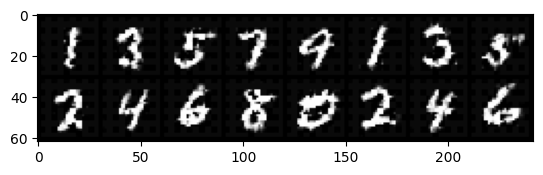

epoch : 10/10, Train loss = 0.021537
epoch : 10/10, Test loss = 0.021908


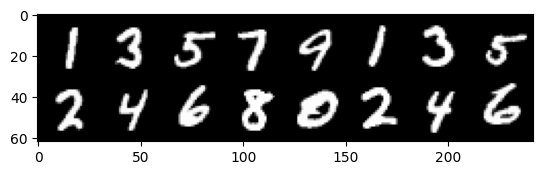

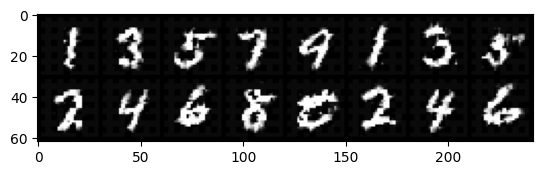

In [68]:
ConvAE_symmetric = ConvAE_symmetric().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(ConvAE_symmetric.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()


epochs=10
for epoch in range(epochs):
    train(ConvAE_symmetric, train_loader, optimizer, criterion, reshape=False)
    test(ConvAE_symmetric, test_loader, criterion, reshape=False)

# Variational Autoencoders (VAEs)

Below we define a variational autoencoder. It takes a vector of 784 elements, and maps it into a mean and a `logvar` of size 20.

Note that `logvar` corresponds to $ln(\sigma^2)$.

In [69]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)

        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

In the case of the VAE, we need to define our own loss function, as we need to combine the reconstruction loss, with the regularisation term (Gaussian prior for the embedding distribution).

> *NOTE: You will see that we use an MSE loss as a reconstruction loss, instead of the negative log likelihood that we should be using... this actually makes sense. We have designed this model so that the output of the decoder is the image - the pixel values (means) and not distributions over the pixel values (e.g. means and variances of a Gaussian).*

> *This is typical in VAE implementations; the output of the decoder is actually the mean $\mu_{x|z}$ (let's just call it $\mu$) and we usually assumes a unitary covariance. So in that case we have: $log(P(x|z))=-{\frac 1 2}[log(|Σ|)+k log(2\pi)+(x−\mu)^T(x−\mu)]$*

> *This comes from taking the log of the probability density function of a multivariate Gaussian distribution. Now you can see that since the first two terms are constant with respect to $\mu$, the optimization problem is equivalent to maximizing $-{\frac 1 2}(x−\mu)^T(x−\mu)$ which is the just the L2 loss between $x$ and $\mu$. Finally the expectation is just approximated by averaging.*

In [70]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    # Reconstruction term
    recLoss = nn.MSELoss(reduction='sum')

    # KL divergence regularisation term
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recLoss(recon_x, x) + KLD

In [71]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VAE().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = loss_function

In [72]:
def train_vae(model, loader, optimizer, criterion):
    loss = 0
    model.train()

    for batch_features, _ in loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()

        # compute reconstructions as well as the embeddings (we need them for the loss)
        outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features, mu, logvar)

        # compute accumulated gradients
        train_loss.backward()

        # perform parameter update based on current gradients
        optimizer.step()

        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()

    # compute the epoch training loss
    loss = loss / len(loader)
    print("epoch : {}/{}, Train loss = {:.6f}".format(epoch + 1, epochs, loss))


def test_vae(model, loader, criterion):
    loss = 0
    model.eval()

    for batch_features, _ in loader:
        batch_features = batch_features.to(device)

        # reshape mini-batch data to [N, 784] matrix (turn images into vectors, and subsume channel)
        batch_features = batch_features.view(-1, 784)

        with torch.no_grad():
            outputs, mu, logvar = model(batch_features)

        # compute training reconstruction loss
        test_loss = criterion(outputs, batch_features, mu, logvar)

        # add the mini-batch training loss to epoch loss
        loss += test_loss.item()

    # compute the epoch test loss
    loss = loss / len(loader)

    # display the epoch training loss
    print("epoch : {}/{}, Test loss = {:.6f}".format(epoch + 1, epochs, loss))
    show_image(make_grid(batch_features.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))
    show_image(make_grid(outputs.detach().cpu().view(-1, 1, 28, 28).transpose(2, 3), nrow=2, normalize = True))

epoch : 1/10, Train loss = 5831.150558
epoch : 1/10, Test loss = 1165.987698


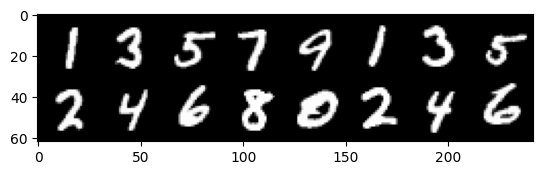

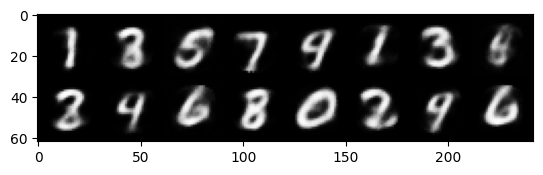

epoch : 2/10, Train loss = 4484.251790
epoch : 2/10, Test loss = 1069.916865


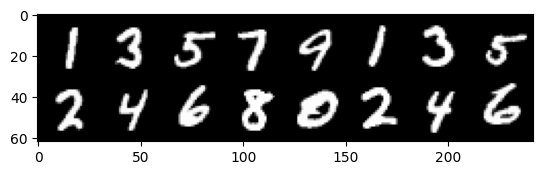

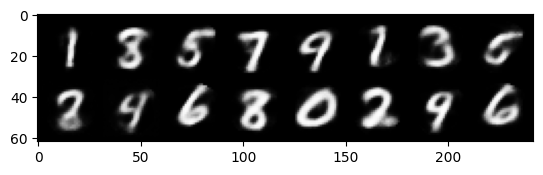

epoch : 3/10, Train loss = 4243.171183
epoch : 3/10, Test loss = 1028.434332


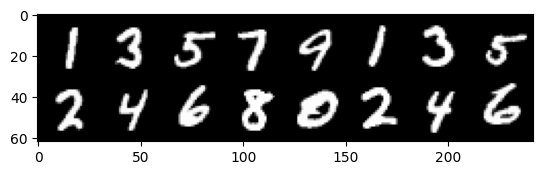

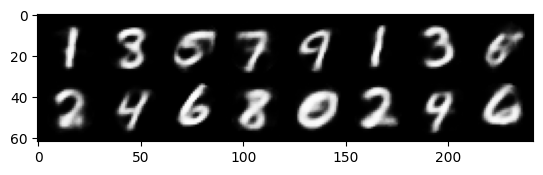

epoch : 4/10, Train loss = 4125.730463
epoch : 4/10, Test loss = 1013.004539


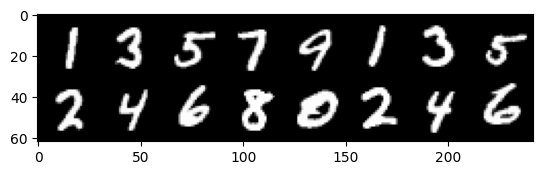

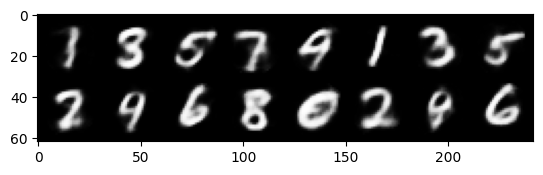

epoch : 5/10, Train loss = 4056.376753
epoch : 5/10, Test loss = 997.785209


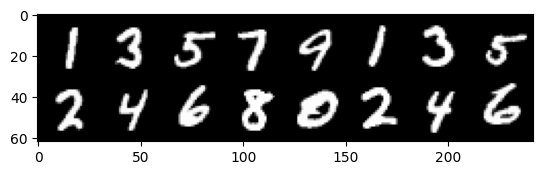

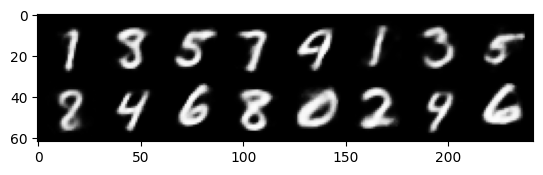

epoch : 6/10, Train loss = 4007.837734
epoch : 6/10, Test loss = 990.746615


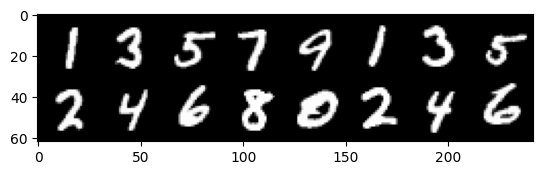

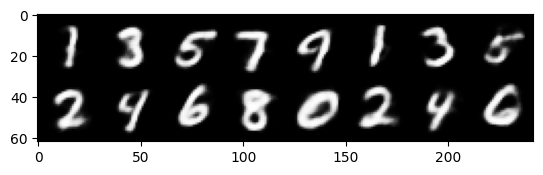

epoch : 7/10, Train loss = 3978.172179
epoch : 7/10, Test loss = 982.419843


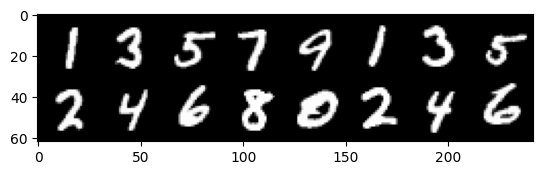

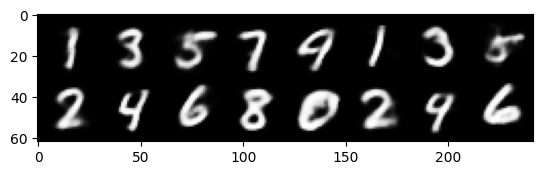

epoch : 8/10, Train loss = 3949.650257
epoch : 8/10, Test loss = 975.143304


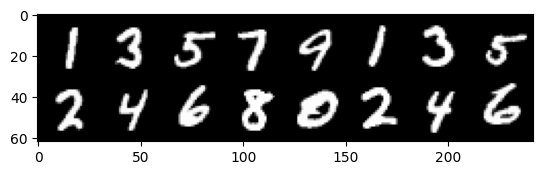

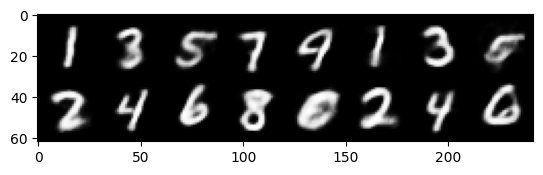

epoch : 9/10, Train loss = 3927.087804
epoch : 9/10, Test loss = 967.419209


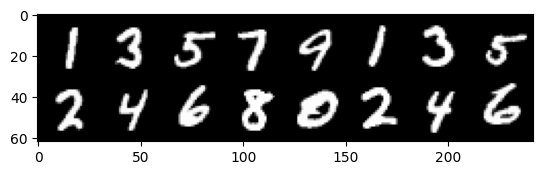

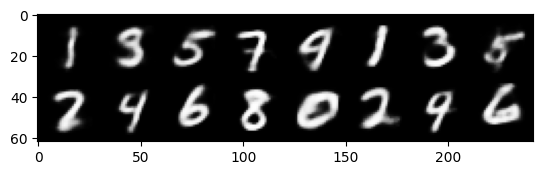

epoch : 10/10, Train loss = 3903.146984
epoch : 10/10, Test loss = 966.977970


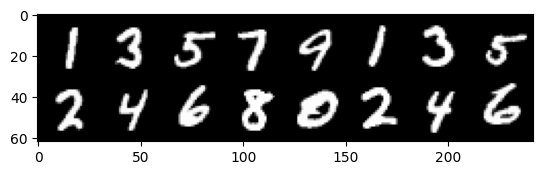

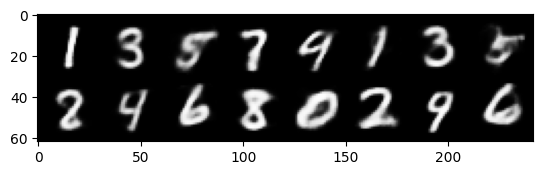

In [73]:
epochs=10
for epoch in range(epochs):
    train_vae(model, train_loader, optimizer, criterion)
    test_vae(model, test_loader, criterion)

We can now use our variational autoencoder to generate new digits. Below we select two digits, and we interpolate between their embeddings to generate embeddings on the line connecting the two original digits. Then we plot them - you should be able to see an evolution from one to the other.

In [74]:
model.eval()

def interpolation(lambda1, model, img1, img2):

    with torch.no_grad():

        # latent vector of first image
        #img1 = img1.view(img1.size(0), -1).to(device)
        img1 = img1.view(-1, 784).to(device)
        latent_1, _ = model.encode(img1)

        # latent vector of second image
        #img2 = img2.view(img2.size(0), -1).to(device)
        img2 = img2.view(-1, 784).to(device)
        latent_2, _ = model.encode(img2)

        # interpolation of the two latent vectors
        inter_latent = (1-lambda1) * latent_1 + lambda1 * latent_2

        # reconstruct interpolated image
        inter_image = model.decode(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image


def visualize_interpolation(model, test_dataloader, digit1 = 7, digit2 = 1):
    # sort part of test set by digit
    digits = [[] for _ in range(10)] # an empty structure to keep samples corresponding to the different digits

    for img_batch, label_batch in test_dataloader:
        for i in range(img_batch.size(0)):
            digits[label_batch[i]].append(img_batch[i:i+1])
        if sum(len(d) for d in digits) >= 1000: # stop when we reach 1000 digits
            break;

    # interpolation lambdas
    lambda_range=np.linspace(0,1,10) # Get 10 points between 0 and 1

    fig, axs = plt.subplots(2,5, figsize=(15, 6))
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()

    for ind,l in enumerate(lambda_range):
        inter_image=interpolation(float(l), model, digits[digit1][0], digits[digit2][0])

        inter_image = inter_image.view(1, 28, 28)

        image = inter_image.numpy()
        axs[ind].imshow(image[0,:,:], cmap='gray')
        axs[ind].set_title('lambda_val='+str(round(l,1)))
    plt.show()

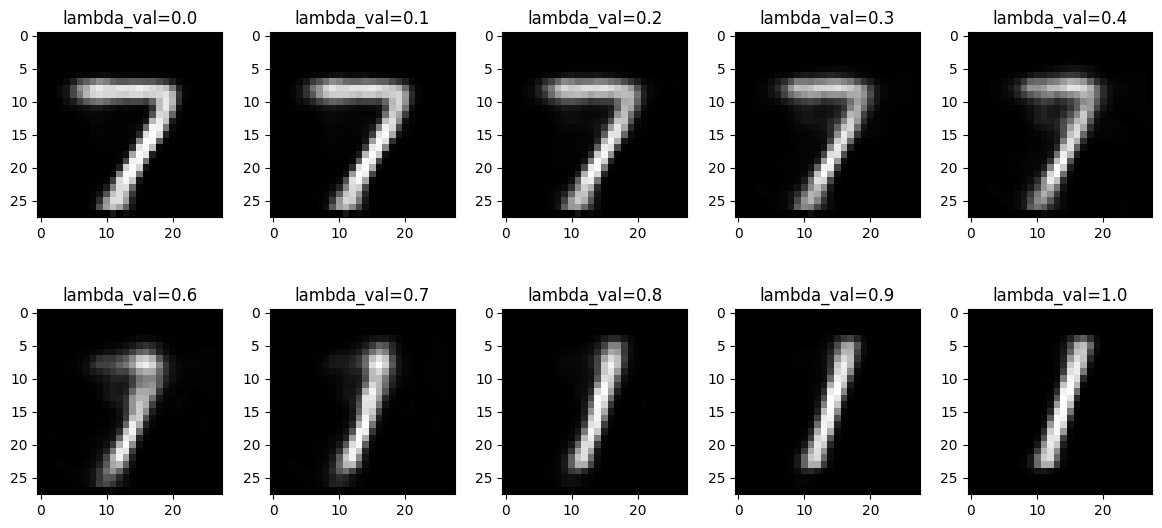

In [75]:
visualize_interpolation(model, test_loader, 7, 1)

<span style="color:blue">

**Exercise 3**: Use the already trained VAE model to generate 100 random new digits.

> Hint: Have a look at PyTorch's `randn()` https://pytorch.org/docs/stable/generated/torch.randn.html
    
</span>

In [86]:
num_samples = 100
latent_dim = 20
random_latent_vectors = torch.randn(num_samples, latent_dim).to(device)


with torch.no_grad():
    #now I should decode the random latent vectors :
    generated_images = model.decode(random_latent_vectors)

#and reshape the generated images:
generated_images = generated_images.view(num_samples, 28, 28).cpu().numpy()


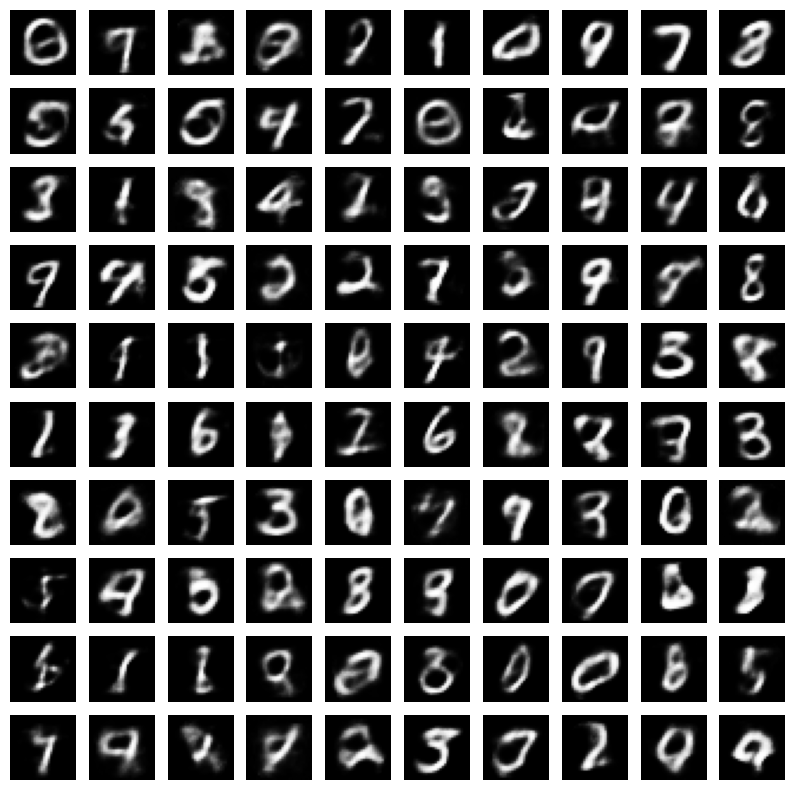

In [87]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap= "gray") # if cmap not set to gray green and blue colors are displayed, looks amazing but I want to keep the same esthetic through all the code
    ax.axis("off") #If I don't set ax.axis to off every subplot will have the axis so I took them off

plt.show()

<span style="color:blue">

**Exercise 4**: Modify the VAE model so that it creates a 2-dimensional latent space. Train it on MNIST and then complete the cell below to visualize the entire 2D latent space.
    
</span>

In [94]:
class VAE2D(nn.Module):
    def __init__(self):
        super(VAE2D, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space
        self.fc22 = nn.Linear(400, 2) #With this little change it would create a 2d latent space instead of a 20d latent space

        self.fc3 = nn.Linear(2, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VAE2D = VAE2D().to(device)

# create an optimizer object
optimizer = torch.optim.Adam(VAE2D.parameters(), lr=1e-3)

criterion = loss_function #loss_function = recLoss(recon_x, x) + KLD



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/10, Train loss = 6261.804919
epoch : 1/10, Test loss = 1378.145468


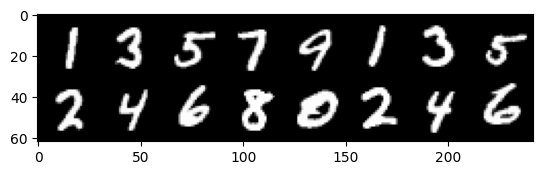

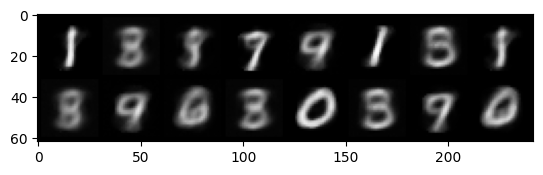

epoch : 2/10, Train loss = 5412.873628
epoch : 2/10, Test loss = 1331.028066


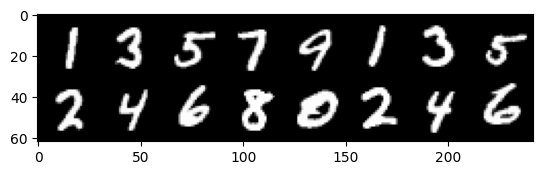

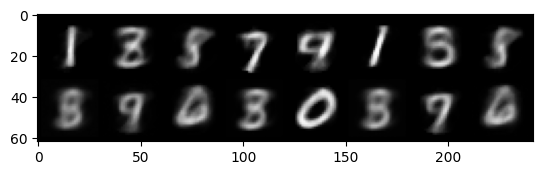

epoch : 3/10, Train loss = 5268.216554
epoch : 3/10, Test loss = 1302.418571


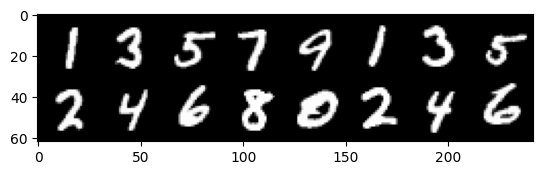

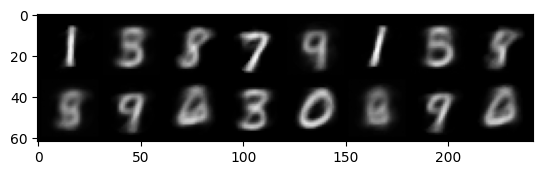

epoch : 4/10, Train loss = 5173.806871
epoch : 4/10, Test loss = 1290.401140


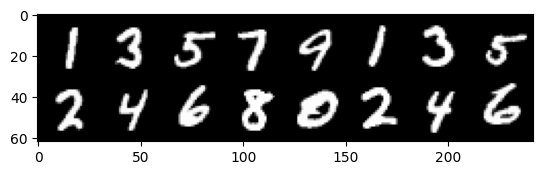

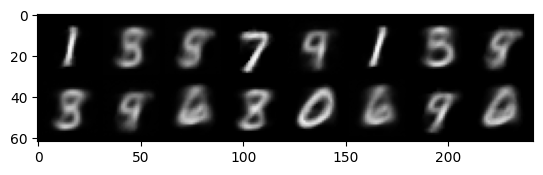

epoch : 5/10, Train loss = 5103.416745
epoch : 5/10, Test loss = 1271.459314


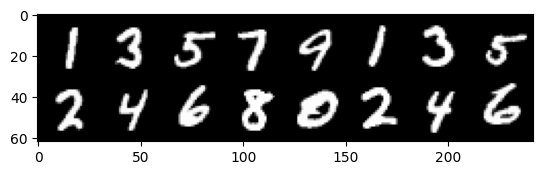

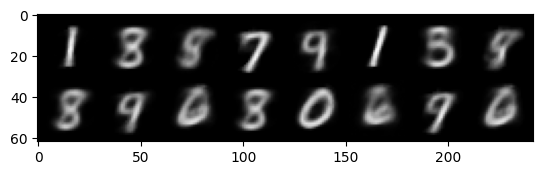

epoch : 6/10, Train loss = 5054.190834
epoch : 6/10, Test loss = 1264.471998


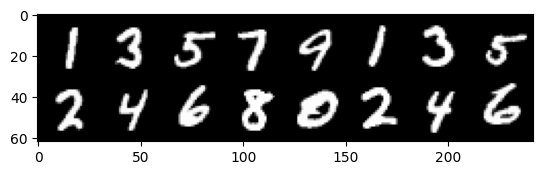

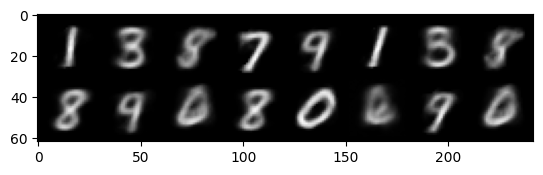

epoch : 7/10, Train loss = 5017.489776
epoch : 7/10, Test loss = 1256.898192


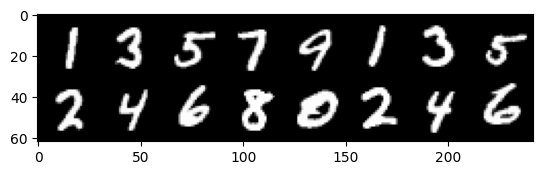

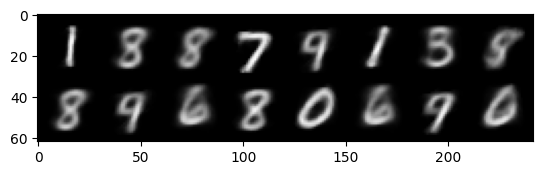

epoch : 8/10, Train loss = 4983.911026
epoch : 8/10, Test loss = 1247.913107


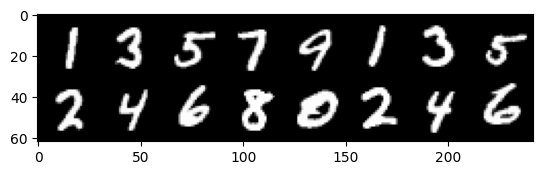

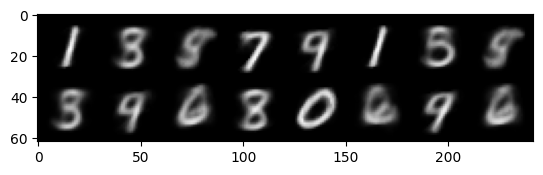

epoch : 9/10, Train loss = 4955.581767
epoch : 9/10, Test loss = 1241.513524


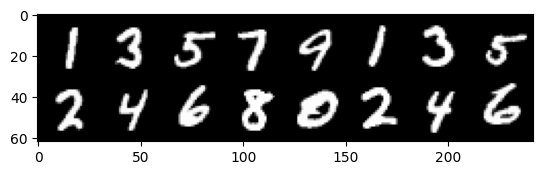

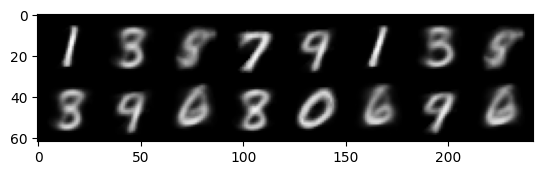

epoch : 10/10, Train loss = 4933.389958
epoch : 10/10, Test loss = 1241.600235


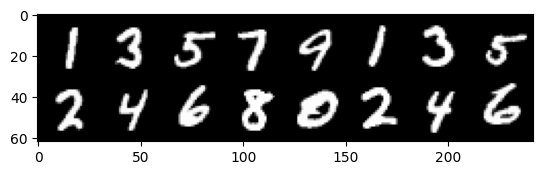

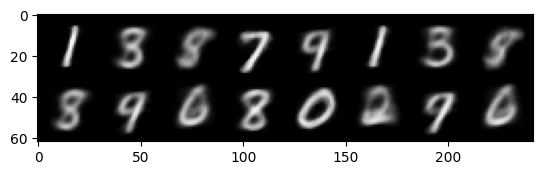

In [95]:
epochs=10
for epoch in range(epochs):
    train_vae(VAE2D, train_loader, optimizer, criterion)
    test_vae(VAE2D, test_loader, criterion)

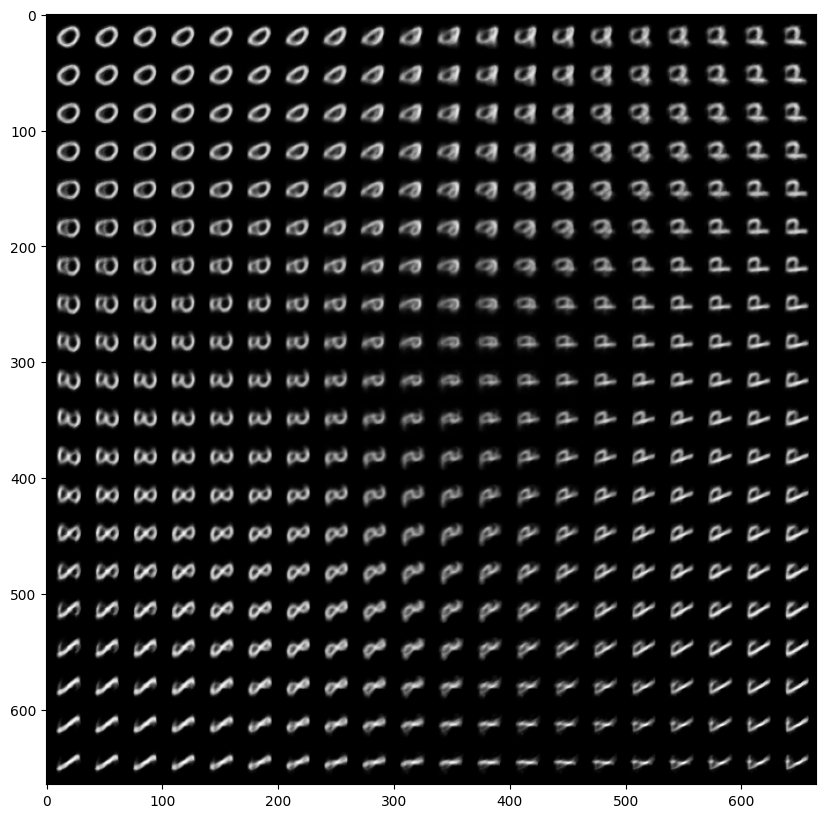

In [96]:
with torch.no_grad():

    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    image_recon = VAE2D.decode(latents.to(device)).cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.view(-1, 1, 28, 28),20,5))
    plt.show()

<span style="color:blue">

**Exercise 5**: Try both the simple encoder and the convolutional encoder with the FashionMNIST dataset, comment what you observe for both results.
    
</span>

In [97]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=True, transform=transform, download=True
)

test_dataset_FMNIST = torchvision.datasets.FashionMNIST(
    root="data", train=False, transform=transform, download=True
)

train_loader_FMNIST = torch.utils.data.DataLoader(
    train_dataset_FMNIST, batch_size=128, shuffle=True, num_workers=2#, pin_memory=True
)

test_loader_FMNIST = torch.utils.data.DataLoader(
    test_dataset_FMNIST, batch_size=32, shuffle=False, num_workers=2
)

100%|██████████| 26421880/26421880 [00:02<00:00, 11576231.79it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200078.36it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3709465.70it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19736999.08it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



# **SIMPLE AUTOENCODER**

epoch : 1/10, Train loss = 0.036423
epoch : 1/10, Test loss = 0.021324


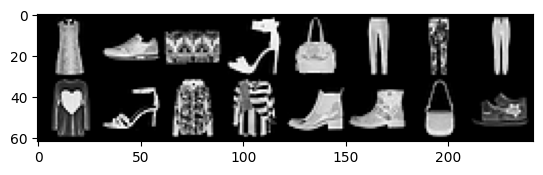

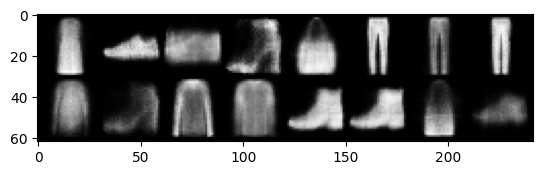

epoch : 2/10, Train loss = 0.019237
epoch : 2/10, Test loss = 0.017694


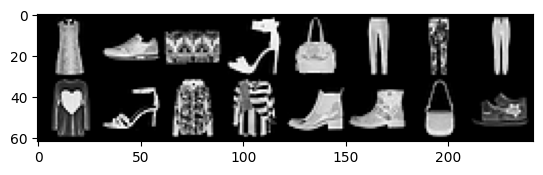

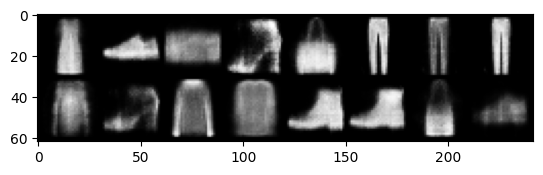

epoch : 3/10, Train loss = 0.016630
epoch : 3/10, Test loss = 0.015703


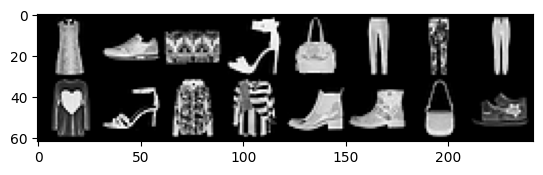

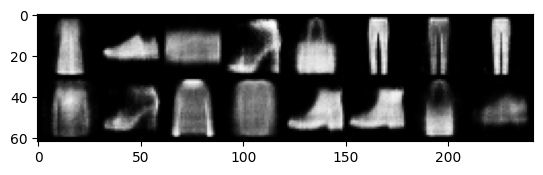

epoch : 4/10, Train loss = 0.014899
epoch : 4/10, Test loss = 0.014232


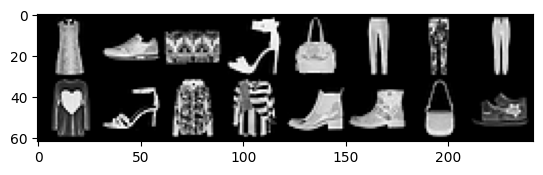

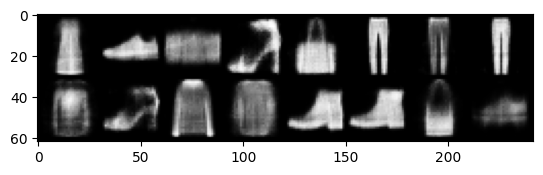

epoch : 5/10, Train loss = 0.013697
epoch : 5/10, Test loss = 0.013387


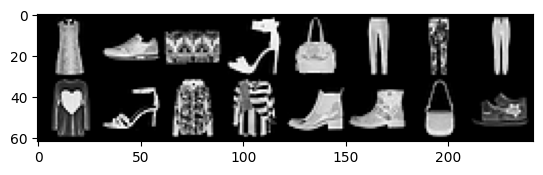

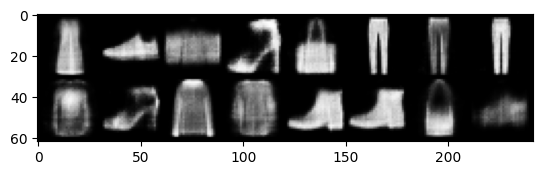

epoch : 6/10, Train loss = 0.012816
epoch : 6/10, Test loss = 0.012514


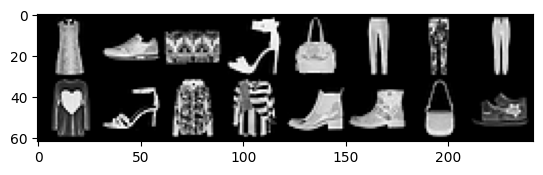

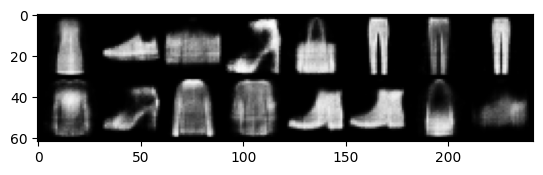

epoch : 7/10, Train loss = 0.012130
epoch : 7/10, Test loss = 0.012297


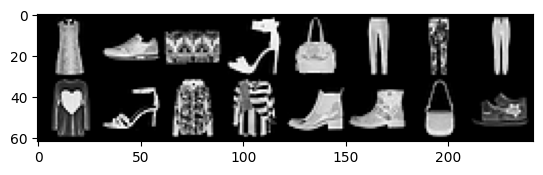

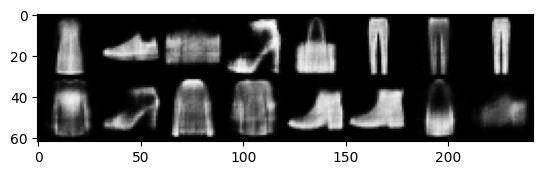

epoch : 8/10, Train loss = 0.011588
epoch : 8/10, Test loss = 0.011489


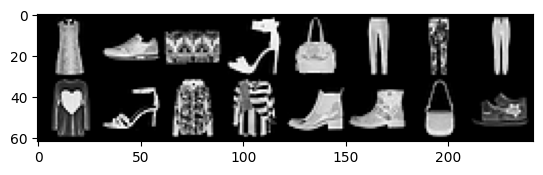

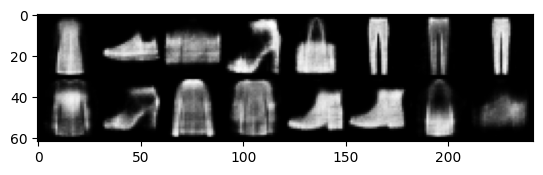

epoch : 9/10, Train loss = 0.011186
epoch : 9/10, Test loss = 0.011129


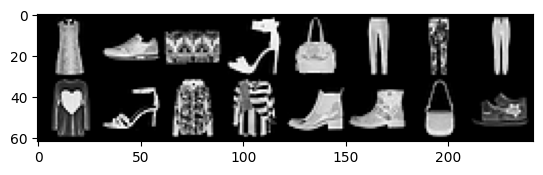

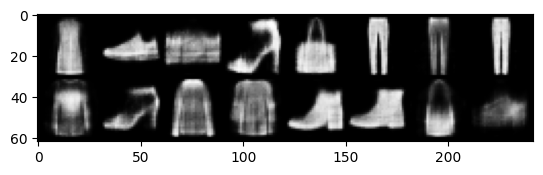

epoch : 10/10, Train loss = 0.010808
epoch : 10/10, Test loss = 0.010735


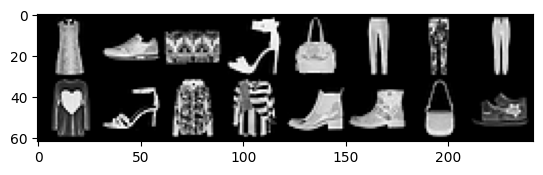

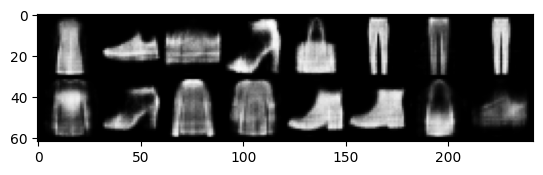

In [98]:
AE = AE(input_size=784).to(device)
optimizer = torch.optim.Adam(AE.parameters(), lr=1e-3)
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(AE, train_loader_FMNIST, optimizer, criterion, reshape=True)
    test(AE, test_loader_FMNIST, criterion, reshape=True)

For the **Simple AutoEncoder**, we can see the resulting values for the training and test set are the following:


---
epoch : 10/10

*   Train loss = 0.010808
*   Test loss = 0.010735




---

The Images Generated look very similar in shape, but are unprecise and very blurry. It seems it is very simple to get the shape of the clothing items, but for the details, such as patterns or others, it does not seems as it is doing a great job.


# **CONVOLUTIONAL AUTOENCODER**

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch : 1/10, Train loss = 0.031097
epoch : 1/10, Test loss = 0.024873


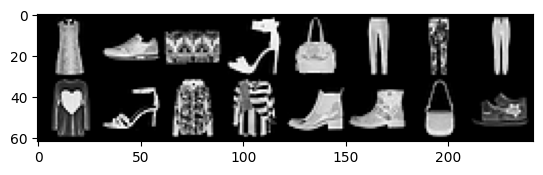

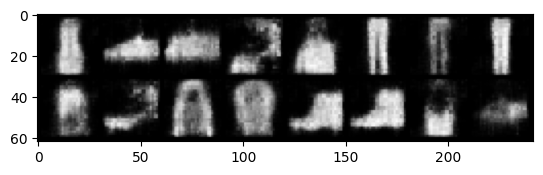

epoch : 2/10, Train loss = 0.023472
epoch : 2/10, Test loss = 0.022531


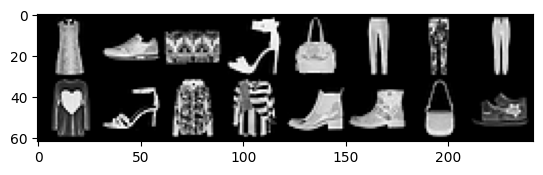

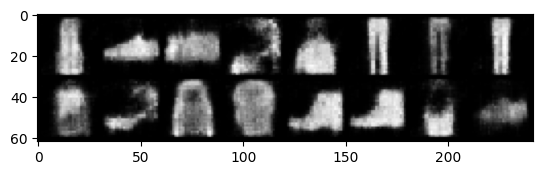

epoch : 3/10, Train loss = 0.021853
epoch : 3/10, Test loss = 0.021660


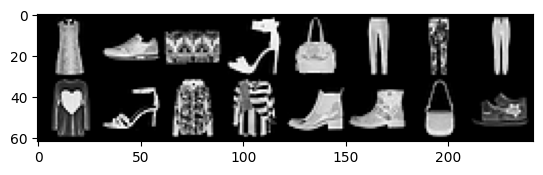

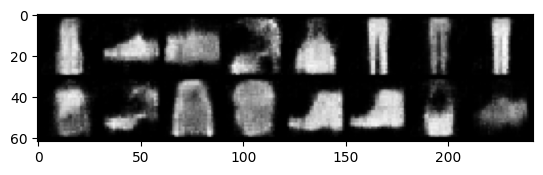

epoch : 4/10, Train loss = 0.021116
epoch : 4/10, Test loss = 0.021025


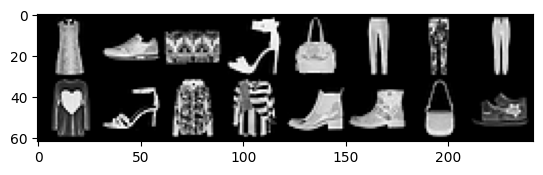

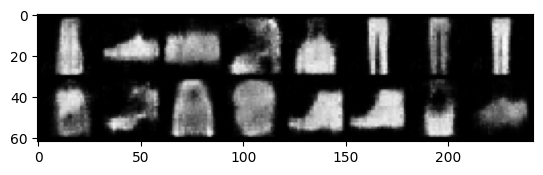

epoch : 5/10, Train loss = 0.020618
epoch : 5/10, Test loss = 0.020370


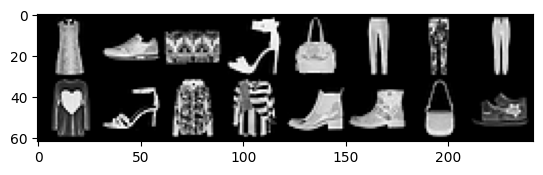

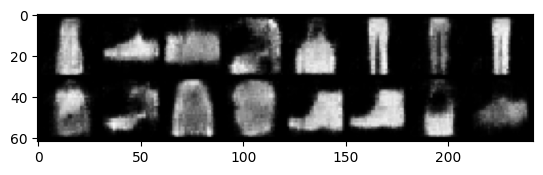

epoch : 6/10, Train loss = 0.020278
epoch : 6/10, Test loss = 0.020614


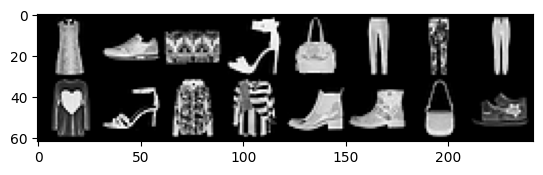

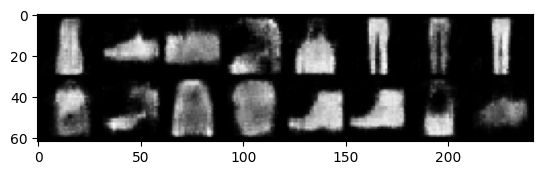

epoch : 7/10, Train loss = 0.020025
epoch : 7/10, Test loss = 0.019923


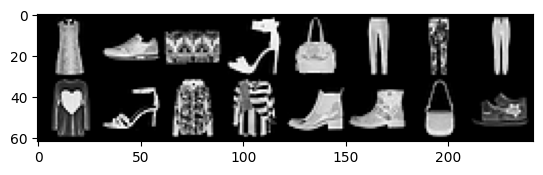

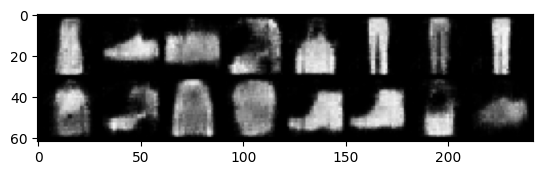

epoch : 8/10, Train loss = 0.019849
epoch : 8/10, Test loss = 0.020224


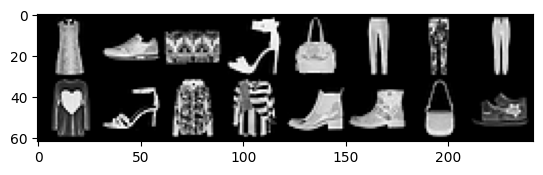

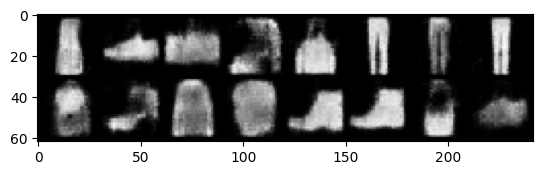

epoch : 9/10, Train loss = 0.019656
epoch : 9/10, Test loss = 0.019698


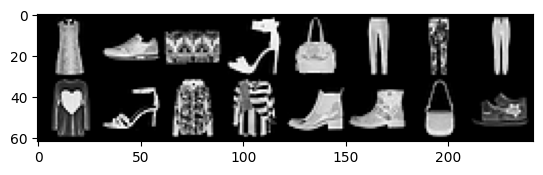

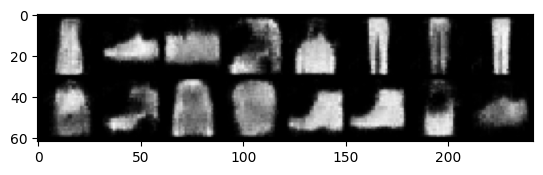

epoch : 10/10, Train loss = 0.019517
epoch : 10/10, Test loss = 0.019440


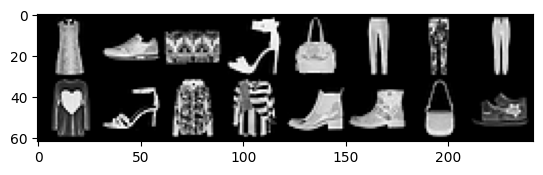

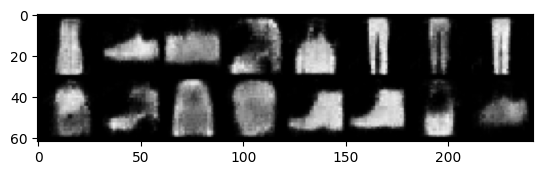

In [99]:
# create an optimizer object
optimizer = torch.optim.Adam(ConvAE.parameters(), lr=4e-3)

# mean-squared error loss
criterion = nn.MSELoss()

epochs=10
for epoch in range(epochs):
    train(ConvAE, train_loader_FMNIST, optimizer, criterion, reshape=False)
    test(ConvAE, test_loader_FMNIST, criterion, reshape=False)



For the **Convolutional AutoEncoder**, we can see the resulting values for the training and test set are the following:


---
epoch : 10/10
*   Train loss = 0.019517
*   Test loss = 0.019440




---

The Images Generated have a lot of the same problems as for the Simple AutoEncoder, but in this case we can see it is a lot less detailed. The problem remains the same, it is very good at getting the shape but not at getting the details and patterns of each individual in the set.



